# Adaptive Boosting Technique

## Load required libraries

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# !pip uninstall -y scikit-learn
!pip install scikit-learn==0.23.2

     |████████████████████████████████| 7.2 MB 1.4 MB/s eta 0:00:01
  Installing build dependencies ... -

In [1]:
import sklearn
print(sklearn.__version__)

0.23.2


## Load dataset and set discrete popularity

In [4]:
df = pd.read_csv('../../Dataset/data_merged.csv')
mean_popularity = 42
df["popularity"] = [ 1 if i >= mean_popularity else 0 for i in df.popularity ]
df["popularity"].head()

0    0
1    0
2    0
3    0
4    0
Name: popularity, dtype: int64

## Initiate sklearn's AdaBoostClassifier

In [5]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=1)

## Prepare and split data to train and test set

In [6]:
X  = df.drop(['popularity'], axis=1)
y = df['popularity']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=21)

## Train the model

In [7]:
ada_clf.fit(X_train, np.ravel(y_train))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=200)

## Testing model

In [8]:
y_train_pred = ada_clf.predict(X_train)

In [9]:
accuracy_score(y_train, y_train_pred)

0.8850011612378795

In [10]:
y_pred = ada_clf.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred)

0.8823666027985833

In [12]:
print(confusion_matrix(y_test, y_pred))
print("Classification report\n")
print(classification_report(y_test, y_pred))

[[24132  1299]
 [ 2753  6262]]
Classification report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     25431
           1       0.83      0.69      0.76      9015

    accuracy                           0.88     34446
   macro avg       0.86      0.82      0.84     34446
weighted avg       0.88      0.88      0.88     34446



## Bayesian Optimization for finding appropriate hyperparameters

In [9]:
!pip install scikit-optimize

     |████████████████████████████████| 101 kB 1.5 MB/s ta 0:00:01
     |████████████████████████████████| 630 kB 6.8 MB/s eta 0:00:01


In [10]:
!pip install matplotlib

In [8]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from matplotlib import pyplot as plt

In [9]:
opt = BayesSearchCV(
    AdaBoostClassifier(),
    {
        'n_estimators' : Integer(50, 250),
        'learning_rate' : Real(0.01, 1.0),
#         'C': (1e-6, 1e+6, 'log-uniform'),
#         'gamma': (1e-6, 1e+1, 'log-uniform'),
#         'degree': (1, 8),  # integer valued parameter
#         'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

In [10]:
opt.fit(X_train, y_train)

from joblib import dump
dump(opt, "Saved models/AdaBoost")

KeyboardInterrupt: 

## Best parameters and scores obtained

In [18]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.8836802531498578
test score: 0.8819892004877199
best params: OrderedDict([('learning_rate', 0.6772353983592146), ('n_estimators', 250)])


In [19]:
y_pred = opt.predict(X_test)

In [20]:
print(confusion_matrix(y_test, y_pred))
print("Classification report\n")
print(classification_report(y_test, y_pred))

[[24106  1325]
 [ 2740  6275]]
Classification report

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     25431
           1       0.83      0.70      0.76      9015

    accuracy                           0.88     34446
   macro avg       0.86      0.82      0.84     34446
weighted avg       0.88      0.88      0.88     34446



## Visualize results with partial dependence plots

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='learning_rate'>,
        <AxesSubplot:xlabel='learning_rate', ylabel='Partial dependence'>]],
      dtype=object)

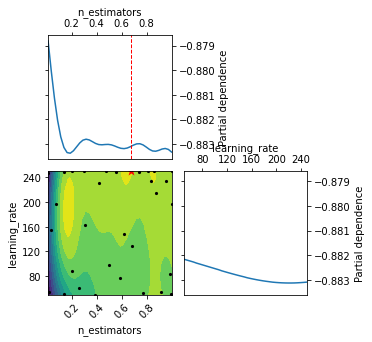

In [21]:
plot_objective(opt.optimizer_results_[0],
                   dimensions=["n_estimators", "learning_rate"],
                       n_minimum_search=int(1e8))